# Wildfire Detection Threshold Model

author : Camen Piho  
last run : Dec 26, 2019

In [28]:
import datetime

import matplotlib.pyplot as plt

from wildfire.goes import downloader, scan

## Introduction

Xu Zhong, an IBM researcher, set up a threshold model to detect wildfires in Australia using the Himawari-8 satellite. It is discussed [in this paper](https://www.researchgate.net/publication/318455389_Real-time_wildfire_detection_and_tracking_in_Australia_using_geostationary_satellite_Himawari-8) and this notebook provides an implementation of their model using GOES-R satellite data to detect wildfires in the United States.

## Data

There was a wilfire on the west coast of the US on October 27, 2019.

In [ ]:
- we a channel (could or could not be a class)
- we have a scan which all 16 channels
    - initialize
        - scan_time
        - region
        - satellite
    - attributes
        - wildfire (bool)
        - scan time
    - some multi-processing (processing, downloading)
    - process()  -- don't process immediately
- we have a sequence which is a list of scans
    - multi-processing lives a lot here (downloading)
    - should this overwrite the process() and download() methods of scan?
        - I think not, we can just call the process() and download() methods of each scan in parallel

In [63]:
def normalize(sample):
    sample_mean = sample.mean()
    sample_sd = sample.std()
    return (sample - sample_mean) / sample_sd


class Scan:
    def __init__(self, satellite, region, scan_time_utc):
        self.satellite = satellite
        self.region = region
        self.scan_time_utc = scan_time_utc
        self.load()
        
    def load(self):
        s3_paths = s3_object_summaries=downloader.query_s3(
            satellite=self.satellite, 
            regions=[self.region], 
            channels=list(range(1, 17)), 
            start=self.scan_time_utc, 
            end=self.scan_time_utc + datetime.timedelta(minutes=1)
        )
        for idx, s3_path in enumerate(s3_paths):
            s3_url = f"s3://{s3_path.bucket_name}/{s3_path.key}"
            setattr(self, f"band_{idx + 1}", scan.read_netcdf(s3_url))
            
    def _is_hot(self):
        return (
            (normalize(self.band_7.dataset.brightness_temperature.data)  > 0.8) & 
            (normalize(self.band_7.dataset.brightness_temperature.data - self.band_14.dataset.brightness_temperature.data) > 1.5)
        )


    def _is_not_water(self):
        return self.band_6.dataset.reflectance_factor.data > 0.05


    def _is_night(self):
        return (
            (np.abs(self.band_2.dataset.reflectance_factor.data[::4, ::4]) < 0.01) | 
            (np.abs(self.band_3.dataset.reflectance_factor.data[::2, ::2]) < 0.01)
        )


    def _is_not_cloud(self):
        band_2 = self.band_2.dataset.reflectance_factor.data[::4, ::4]
        band_3 = self.band_3.dataset.reflectance_factor.data[::2, ::2]
        band_15 = self.band_15.dataset.brightness_temperature.data
        return (
            ((band_2 + band_3) < 1.2) &
            (band_15 > 265) &
            (
                ((band_2 + band_3) < 0.7) | (band_15 > 285)
            )
        )


    def plot_has_wildfire(self):
        fig, axes = plt.subplots(ncols=2, figsize=(14, 20))
        axes[0].imshow((self._is_hot()) & (self._is_not_water()) & (self._is_not_cloud()))
        axes[1].imshow(self.band_7.dataset.brightness_temperature)
        plt.show();

Regions: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


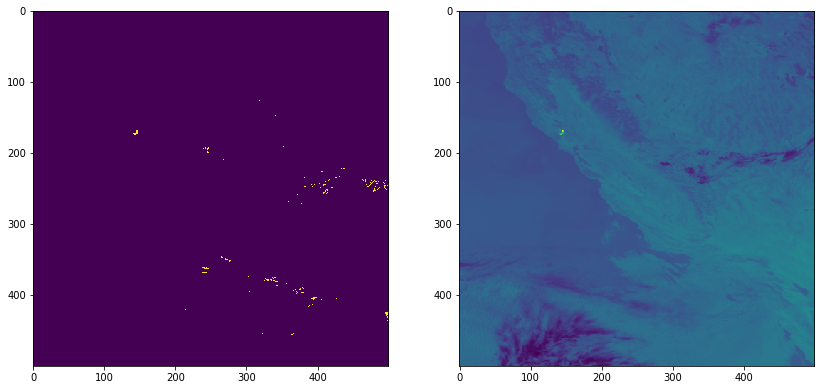

In [107]:
goes_scan_1 = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 27, 20, 0))
goes_scan_1.plot_has_wildfire()

Regions: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


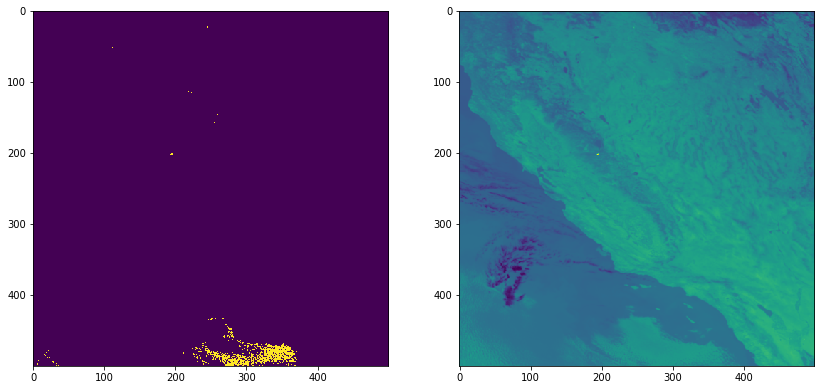

In [95]:
goes_scan_2 = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 10, 20, 0))
goes_scan_2.plot_has_wildfire()

Regions: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


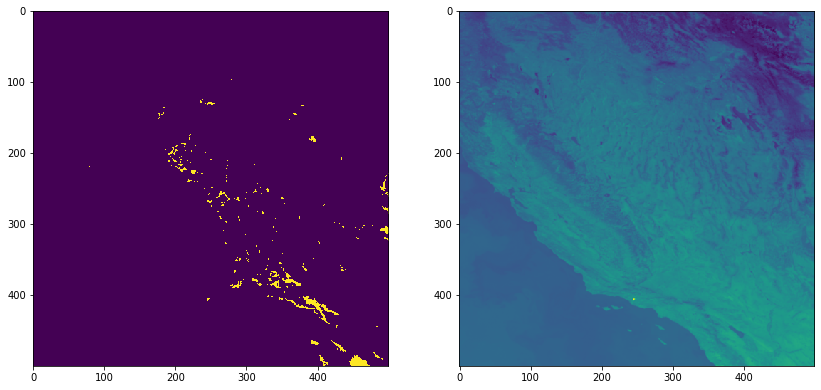

In [104]:
goes_scan_3 = Scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 11, 1, 18, 0))
goes_scan_3.plot_has_wildfire()

In [130]:
goes_scan_1.band_14.dataset.band_wavelength

<xarray.DataArray 'band_wavelength' (band: 1)>
array([11.19], dtype=float32)
Coordinates:
    t                datetime64[ns] ...
    y_image          float32 ...
    x_image          float32 ...
    band_id          (band) int8 ...
    band_wavelength  (band) float32 11.19
Dimensions without coordinates: band
Attributes:
    long_name:      ABI band central wavelength
    standard_name:  sensor_band_central_radiation_wavelength
    units:          um

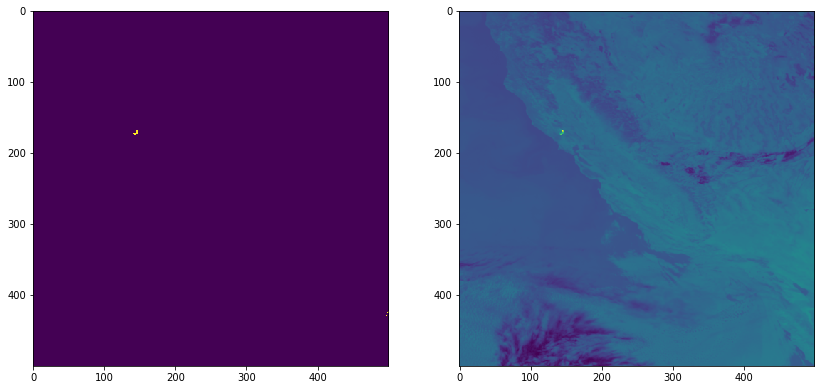

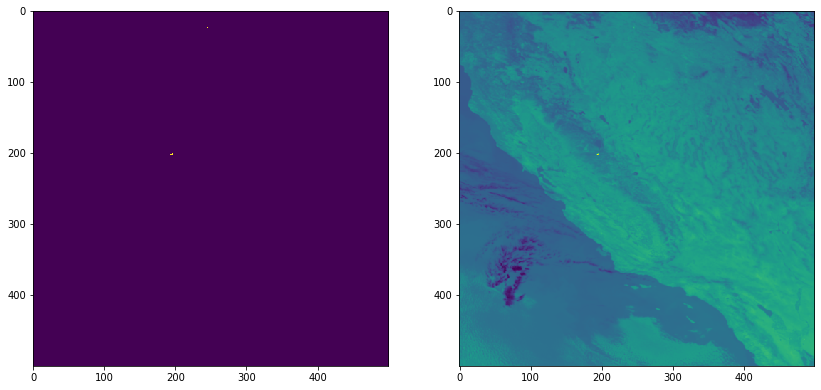

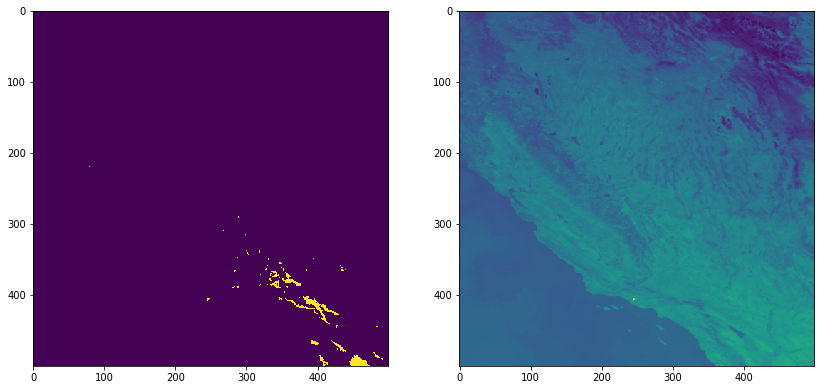

In [115]:
def is_hot(band_7, band_14):
    return (
#         (normalize(band_7.dataset.brightness_temperature.data) > 0.8) & 
        (normalize(band_7.dataset.brightness_temperature.data) > 1.5) & 
        (normalize(band_7.dataset.brightness_temperature.data - band_14.dataset.brightness_temperature.data) > 1.5)
    )


def is_not_water(band_6):
    return band_6.dataset.reflectance_factor.data > 0.05


def is_night(band_2, band_3):
    return (
        (np.abs(band_2.dataset.reflectance_factor.data[::4, ::4]) < 0.01) | 
        (np.abs(band_3.dataset.reflectance_factor.data[::2, ::2]) < 0.01)
    )


def is_not_cloud(band_2, band_3, band_15):
    band_2 = band_2.dataset.reflectance_factor.data[::4, ::4]
    band_3 = band_3.dataset.reflectance_factor.data[::2, ::2]
    band_15 = band_15.dataset.brightness_temperature.data
    return (
        ((band_2 + band_3) < 1.2) &
        (band_15 > 265) &
        (
            ((band_2 + band_3) < 0.7) | (band_15 > 285)
        )
    )


def plot_has_wildfire(g_scan):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 20))
    axes[0].imshow((is_hot(g_scan.band_7, g_scan.band_14)) & (is_not_water(g_scan.band_6)) & (is_not_cloud(g_scan.band_2, g_scan.band_3, g_scan.band_15)))
    axes[1].imshow(g_scan.band_7.dataset.brightness_temperature)
    plt.show();
    
    
plot_has_wildfire(goes_scan_1)
plot_has_wildfire(goes_scan_2)
plot_has_wildfire(goes_scan_3)

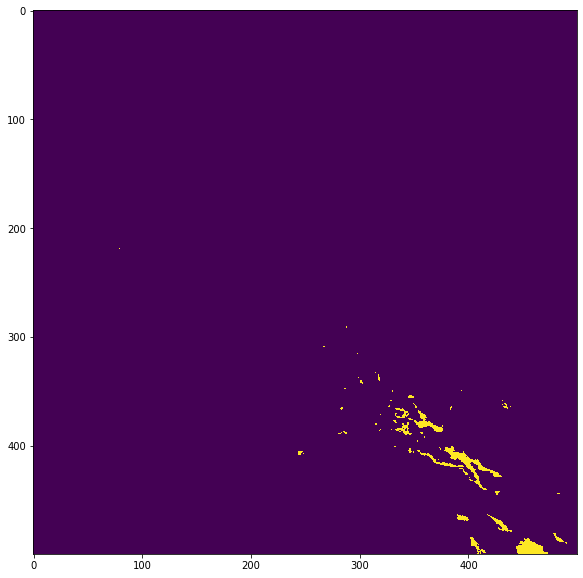

In [134]:
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(is_hot(goes_scan_3.band_7, goes_scan_3.band_14))

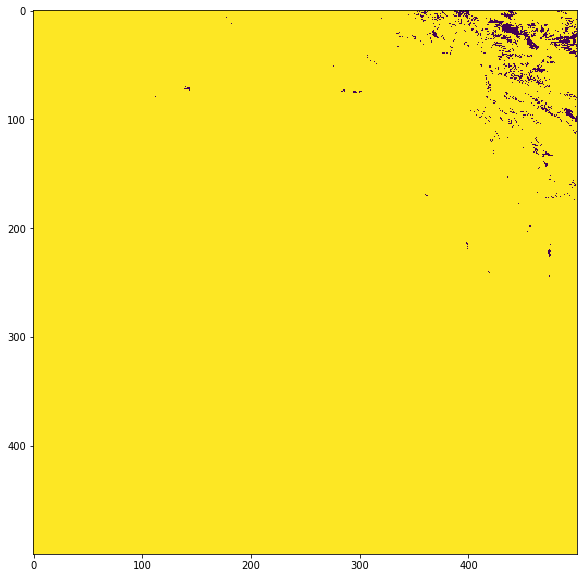

In [138]:
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(is_not_cloud(goes_scan_3.band_2, goes_scan_3.band_3, goes_scan_3.band_15))

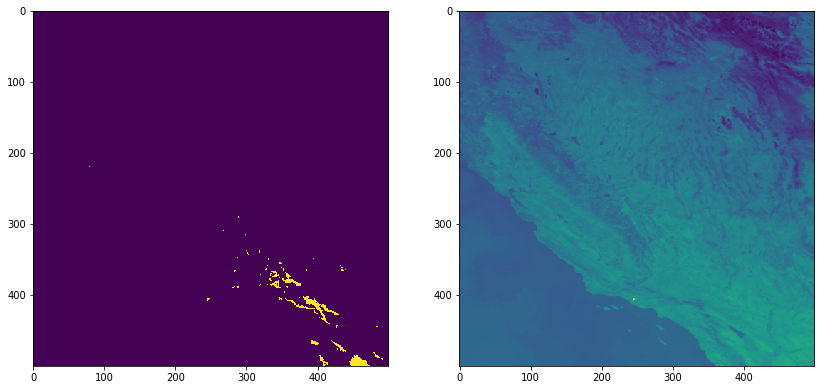

In [140]:
plot_has_wildfire(goes_scan_3)

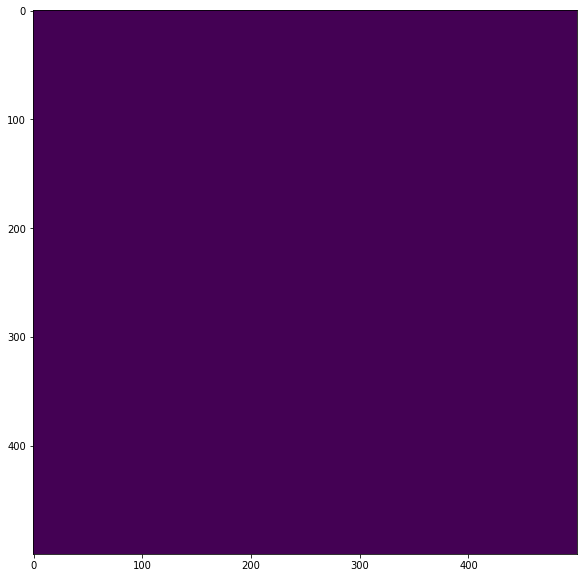

In [144]:
band_2 = goes_scan_3.band_2.dataset.reflectance_factor.data[::4, ::4]
band_3 = goes_scan_3.band_3.dataset.reflectance_factor.data[::2, ::2]
band_15 = goes_scan_3.band_15.dataset.brightness_temperature.data
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    ((band_2 + band_3) < 10)
#     (band_15 > 265) &
#     (
#         ((band_2 + band_3) < 0.7) | (band_15 > 285)
#     )
)

In [169]:
(goes_scan_3.band_2.dataset.reflectance_factor < 10).astype(int)

<xarray.DataArray 'reflectance_factor' (y: 2000, x: 2000)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.118713 0.118699 0.118685 ... 0.090741 0.090727
  * x        (x) float32 0.029687 0.029701 0.029715 ... 0.057659 0.057673
    y_image  float32 ...
    x_image  float32 ...

In [145]:
goes_scan.band_2.dataset.reflectance_factor

<xarray.DataArray 'reflectance_factor' (y: 2000, x: 2000)>
array([[0.03870833, 0.03749928, 0.03780154, ..., 0.08374525, 0.07618871,
        0.07830454],
       [0.03749928, 0.03689476, 0.03870833, ..., 0.10550805, 0.08979047,
        0.07830454],
       [0.03689476, 0.03931285, 0.03931285, ..., 0.08948821, 0.08314073,
        0.09855605],
       ...,
       [0.1160872 , 0.11790076, 0.1986045 , ..., 0.0420332 , 0.04142867,
        0.04233546],
       [0.16535577, 0.06742315, 0.11548267, ..., 0.04112641, 0.0420332 ,
        0.04021963],
       [0.06742315, 0.06560957, 0.12575956, ..., 0.04021963, 0.03991737,
        0.04142867]])
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.115353 0.115339 0.115325004 ... 0.087381005 0.087367
  * x        (x) float32 0.024647 0.024660999 ... 0.052619 0.052633002
    y_image  float32 ...
    x_image  float32 ...

In [146]:
goes_scan.band_3.dataset.reflectance_factor

<xarray.DataArray 'reflectance_factor' (y: 1000, x: 1000)>
array([[0.01476433, 0.01354035, 0.01354035, ..., 0.22773785, 0.22896185,
        0.20570611],
       [0.01598831, 0.01476433, 0.01476433, ..., 0.21549799, 0.21182603,
        0.22528989],
       [0.01476433, 0.01476433, 0.01476433, ..., 0.20081016, 0.20203416,
        0.22528989],
       ...,
       [0.09187543, 0.11880312, 0.12247507, ..., 0.02088426, 0.02210825,
        0.03557209],
       [0.15307472, 0.21794598, 0.11513116, ..., 0.02088426, 0.02088426,
        0.02088426],
       [0.09187543, 0.14940276, 0.17633046, ..., 0.02088426, 0.01966027,
        0.01966027]])
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.115346 0.115318 0.11529 ... 0.08743 0.087402 0.087374
  * x        (x) float32 0.024654 0.024681998 0.02471 ... 0.052598 0.052626
    y_image  float32 ...
    x_image  float32 ...

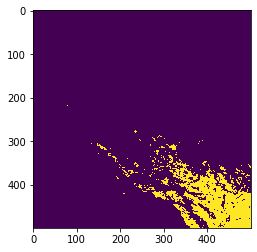

In [173]:
plt.imshow(normalize(goes_scan_3.band_7.dataset.brightness_temperature.data) > 1.5)

In [174]:
normalize(goes_scan_3.band_7.dataset.brightness_temperature.data) > 1.5

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])